# Homework Assignment 6

## Topics: RFE (recursive feature elimination), feature selection

In [1]:
import boto3
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import precision_recall_cutoff as prc
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report

## 1. Using pandas to read the data files

## Defining the bucket
s3 = boto3.resource('s3')
bucket_name = 'data-448-bucket-callaghan'
bucket = s3.Bucket(bucket_name)

file_key = 'train.csv'
file_key2 = 'test.csv'

bucket_object = bucket.Object(file_key)
bucket_object2 = bucket.Object(file_key2)

file_object = bucket_object.get()
file_object2 = bucket_object2.get()

file_content_stream = file_object.get('Body')
file_content_stream2 = file_object2.get('Body')

train = pd.read_csv(file_content_stream, sep = '|')
test = pd.read_csv(file_content_stream2, sep = '|')

train.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0


In [2]:
## Creating variables from previous homework assignments

## Training set:

## Variable 1 (from decision tree)
train['Interaction_1'] = np.where((train['trustLevel'] <= 1.5) & (train['scannedLineItemsPerSecond'] <= 0.012) & 
                                  (train['lineItemVoids'] <= 10.5), 0, 1)
## Variable 2 (from decision tree)
train['Interaction_2'] = np.where((train['trustLevel'] <= 1.5) & (train['scannedLineItemsPerSecond'] > 0.012) & 
                                  (train['totalScanTimeInSeconds'] <= 895.0), 0, 1)
## Variable 3 (from decision tree)
train['Interaction_3'] = np.where((train['trustLevel'] > 1.5) & (train['grandTotal'] <= 99.145) & 
                                  train['trustLevel'] <= 2.5, 1, 0)
## Variable 4 (from decision tree)
train['Interaction_4'] = np.where((train['trustLevel'] > 1.5) & (train['grandTotal'] > 99.145) & 
                                  train['valuePerSecond'] <= 0.06, 1, 0)
## Variable 5 - Low trustLevel (all frauds came from trustLevel = 1 or 2)
train['lowTrust'] = np.where(train['trustLevel'] <= 2, 1, 0)

## Variable 6 - Made a quantity modification
train['madeModification'] = np.where(train['quantityModifications'] > 0, 1, 0)

## Variable 7 - Attempted a scan without registration
train['madeScansWithoutRegistration'] = np.where(train['scansWithoutRegistration'] > 0, 1, 0)

## Variable 8 - High or low totalScanTimeInSeconds (huge differnece in mean and median values for fraud/not fraud in this field)
train['lowTotalScanTime'] = np.where(train['totalScanTimeInSeconds'] < 1000, 1, 0)

## Varibales from strong heredity principle
train['Heredity_Feature_1'] = train['trustLevel'] * train['lowTrust']
train['Heredity_Feature_2'] = train['trustLevel'] * train['scannedLineItemsPerSecond']
train['Heredity_Feature_3'] = train['lowTrust'] * train['scannedLineItemsPerSecond']

## Heredity_Feature_3: all observations less than 0.012 are not fraud in this tree
train['New_Interaction_1'] = np.where(train['Heredity_Feature_3'] <= 0.012, 1, 0)

## Lots of positove observations when Heredity_Feature_3 > 0.012, totalScanTimeInSeconds > 1298.0, and trustLevel <= 1.5
train['New_Interaction_2'] = np.where((train['Heredity_Feature_3'] > 0.012) & (train['totalScanTimeInSeconds'] > 1298.0) 
                                      & (train['trustLevel'] < 1.5), 1, 0)

## Mostly all negative observations when Heredity_Feature_3 > 0.012, totalScanTimeInSeconds <= 1298.0, and Heredity_Feature_1 > 0.119
train['New_Interaction_3'] = np.where((train['Heredity_Feature_3'] > 0.012) & (train['totalScanTimeInSeconds'] <= 1298.0) 
                                      & (train['Heredity_Feature_1'] > 1.5), 1, 0)

In [3]:
## Testing set:

## Variable 1
test['Interaction_1'] = np.where((test['trustLevel'] <= 1.5) & (test['scannedLineItemsPerSecond'] <= 0.012) & 
                                  (test['lineItemVoids'] <= 10.5), 0, 1)
## Variable 2
test['Interaction_2'] = np.where((test['trustLevel'] <= 1.5) & (test['scannedLineItemsPerSecond'] > 0.012) & 
                                  (test['totalScanTimeInSeconds'] <= 895.0), 0, 1)
## Variable 3
test['Interaction_3'] = np.where((test['trustLevel'] > 1.5) & (test['grandTotal'] <= 99.145) & 
                                  test['trustLevel'] <= 2.5, 1, 0)
## Variable 4
test['Interaction_4'] = np.where((test['trustLevel'] > 1.5) & (test['grandTotal'] > 99.145) & 
                                  test['valuePerSecond'] <= 0.06, 1, 0)
## Variable 5 - Low trustLevel
test['lowTrust'] = np.where(test['trustLevel'] <= 2, 1, 0)

## Variable 6 - Made a quantity modification
test['madeModification'] = np.where(test['quantityModifications'] > 0, 1, 0)

## Variable 7 - Attempted a scan without registration
test['madeScansWithoutRegistration'] = np.where(test['scansWithoutRegistration'] > 0, 1, 0)

## Variable 8 - High or low totalScanTimeInSeconds
test['lowTotalScanTime'] = np.where(test['totalScanTimeInSeconds'] < 1000, 1, 0)

## Varibales from strong heredity principle
test['Heredity_Feature_1'] = test['trustLevel'] * test['lowTrust']
test['Heredity_Feature_2'] = test['trustLevel'] * test['scannedLineItemsPerSecond']
test['Heredity_Feature_3'] = test['lowTrust'] * test['scannedLineItemsPerSecond']

test['New_Interaction_1'] = np.where(test['Heredity_Feature_3'] <= 0.012, 1, 0)

test['New_Interaction_2'] = np.where((test['Heredity_Feature_3'] > 0.012) & (test['totalScanTimeInSeconds'] > 1298.0) 
                                      & (test['trustLevel'] < 1.5), 1, 0)

test['New_Interaction_3'] = np.where((test['Heredity_Feature_3'] > 0.012) & (test['totalScanTimeInSeconds'] <= 1298.0) 
                                      & (test['Heredity_Feature_1'] > 1.5), 1, 0)

In [4]:
## 2. Using the train data-frame to do the following:

## i) Splitting the train data-frame into training (80%) and testing (20%)

## Defining the input and target variables
X = train.drop(columns = ['fraud'])
Y = train['fraud']

## Defining empty list to store results
results_rfe = []
logit_support = []
rf_support = []
ada_support = []

## Repeating steps 100 times:
for i in tqdm(range(0, 100)):
    
    ## Splitting the data
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)
    
    
    ## Runing RFE (recursive feature elimination) with logistic regression as a base algorithm (with n_features_to_select = 5)
    logit_rfe = RFE(estimator = LogisticRegression(max_iter = 10000), n_features_to_select = 5).fit(X_train, Y_train)
    
    ## Appending the features to be selected
    results_rfe.append(logit_rfe.support_)
    logit_support.append(logit_rfe.support_)
    
    
    ## Runing RFE (recursive feature elimination) with random forest (with 500 trees and max depth equal to 3) as a base algorithm 
    ## (with n_features_to_select = 5)
    rf_rfe = RFE(estimator = RandomForestClassifier(max_depth = 3, n_estimators = 500), n_features_to_select = 5).fit(X_train, Y_train)
    
    ## Appending the features to be selected
    results_rfe.append(rf_rfe.support_)
    rf_support.append(rf_rfe.support_)
    
    
    ## Runing RFE (recursive feature elimination) with AdaBoost (with 500 trees, max depth equal to 3, and learning rate equal to 0.01) 
    ## as a base algorithm (with n_features_to_select = 5)
    ada_rfe = RFE(estimator = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 3), n_estimators = 500, 
                                                learning_rate = 0.01), n_features_to_select = 5).fit(X_train, Y_train)
    
    ## Appending the features to be selected
    results_rfe.append(ada_rfe.support_)
    ada_support.append(ada_rfe.support_)

100%|██████████| 100/100 [1:39:56<00:00, 59.96s/it]


In [5]:
## Changing result lists to data-frames

## Logistic Regression
logit_support = pd.DataFrame(logit_support, columns = X.columns)
logit = 100 * logit_support.apply(np.sum, axis = 0) / logit_support.shape[0]

## Random Forest
rf_support = pd.DataFrame(rf_support, columns = X.columns)
rf = 100 * rf_support.apply(np.sum, axis = 0) / rf_support.shape[0]

## AdaBoost
ada_support = pd.DataFrame(ada_support, columns = X.columns)
ada = 100 * ada_support.apply(np.sum, axis = 0) / ada_support.shape[0]

## Overall
results_rfe = pd.DataFrame(results_rfe, columns = X.columns)
results = 100 * results_rfe.apply(np.sum, axis = 0) / results_rfe.shape[0]

Text(0.5, 1.0, 'Overall Results')

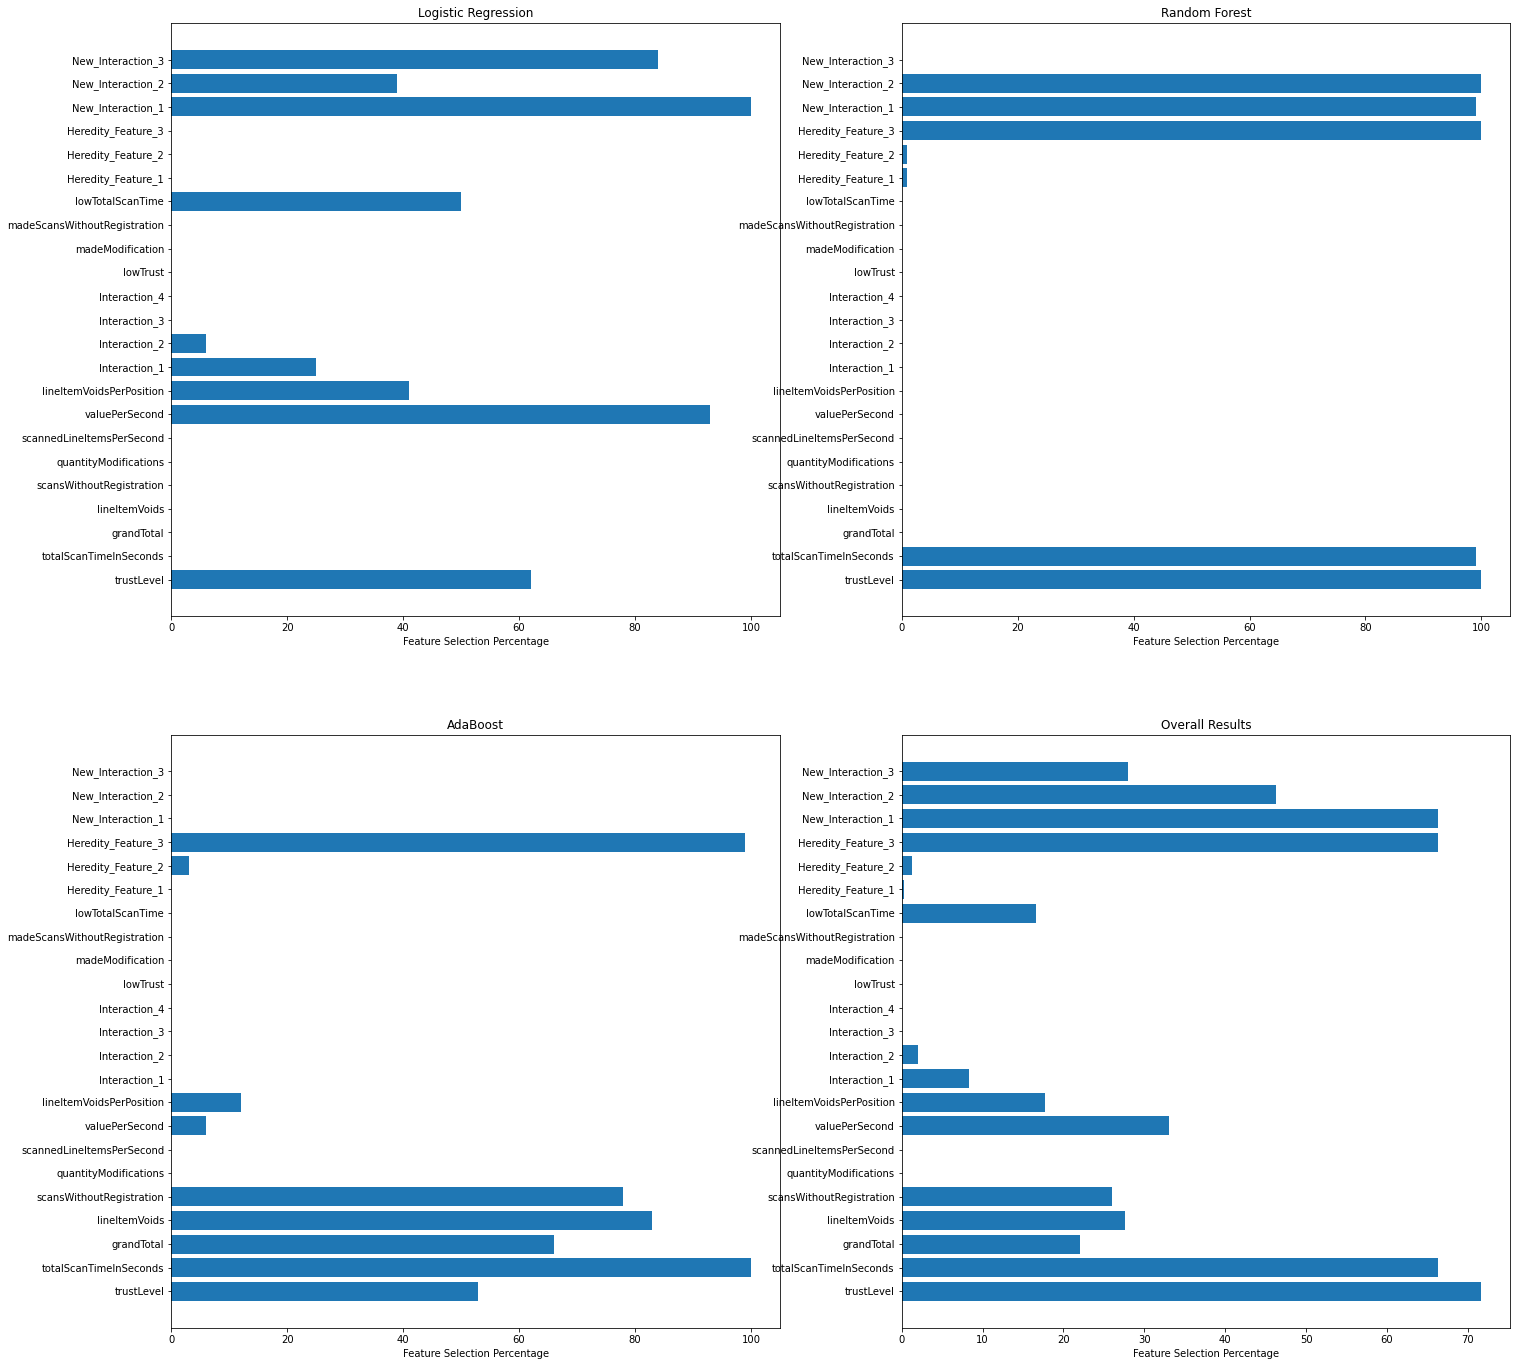

In [6]:
## Graphing results

fig, axes = plt.subplots(2, 2, figsize = (24, 24))

axes[0, 0].barh(logit.index, logit.values)
axes[0, 0].set_xlabel('Feature Selection Percentage')
axes[0, 0].set_title('Logistic Regression')

axes[0, 1].barh(rf.index, rf.values)
axes[0, 1].set_xlabel('Feature Selection Percentage')
axes[0, 1].set_title('Random Forest')

axes[1, 0].barh(ada.index, ada.values)
axes[1, 0].set_xlabel('Feature Selection Percentage')
axes[1, 0].set_title('AdaBoost')

axes[1, 1].barh(results.index, results.values)
axes[1, 1].set_xlabel('Feature Selection Percentage')
axes[1, 1].set_title('Overall Results')

#### Top-5 Variables: trustLevel, New_Interaction_1, Heredity_Feature_3, totalScanTimeInSeconds, New_Interaction_2

## Modeling with all variables vs. Top-5 overall from RFE

In [9]:
## All variables

## Defining the input and target variables
X = train.drop(columns = ['fraud'])
Y = train['fraud']

## Splitting the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)

## Building the models
rf_md = RandomForestClassifier(max_depth = 5, n_estimators = 500).fit(X_train, Y_train)

## Predicting on the test set
rf_preds = rf_md.predict_proba(X_test)[:, 1]

## Using the precision-recall curve function to extract prediction labels
rf_labels = prc.precision_recall_cutoff(Y_test, rf_preds)

## Computing the classification report
print(classification_report(Y_test, rf_labels))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       355
           1       0.73      0.76      0.74        21

    accuracy                           0.97       376
   macro avg       0.86      0.87      0.86       376
weighted avg       0.97      0.97      0.97       376



In [10]:
## Top-5 variables

## Defining the input and target variables
X = train[['trustLevel', 'New_Interaction_1', 'Heredity_Feature_3', 'totalScanTimeInSeconds', 'New_Interaction_2']]
Y = train['fraud']

## Splitting the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)

## Building the models
rf_md = RandomForestClassifier(max_depth = 5, n_estimators = 500).fit(X_train, Y_train)

## Predicting on the test set
rf_preds = rf_md.predict_proba(X_test)[:, 1]

## Using the precision-recall curve function to extract prediction labels
rf_labels = prc.precision_recall_cutoff(Y_test, rf_preds)

## Computing the classification report
print(classification_report(Y_test, rf_labels))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       355
           1       0.86      0.86      0.86        21

    accuracy                           0.98       376
   macro avg       0.92      0.92      0.92       376
weighted avg       0.98      0.98      0.98       376



#### Based on the classification reports, we can see that the Radom Forest Classifier model with the top-5 input variables had slightly better prediction power over the model with all possible input variables. 